<a href="https://colab.research.google.com/github/seisbench/seisbench/blob/additional_example_workflows/examples/01c_generator_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

*This code is necessary on colab to install SeisBench. If SeisBench is already installed on your machine, you can skip this.*

In [ ]:
!pip install seisbench

# Generator pipelines

This tutorial introduces the SeisBench generator pipelines. Generator pipelines are an easy way to generate training examples for deep learning models. They can be used for simple window selection, label generation, and even data augmentation.

*Note: It is recommended to have a look at the dataset basics tutorial before following this tutorial.*

In [1]:
import seisbench.data as sbd
import seisbench.generate as sbg

## The generator object

All generation pipelines are based on SeisBench datasets. For this tutorial, we'll use the ETHZ dataset. If this dataset is not locally available, it will automatically be downloaded to your SeisBench cache. This might take a moment.

In [2]:
data = sbd.ETHZ(sampling_rate=100)

2021-09-10 16:27:45,704 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
/data_ssd/home/munchmej/code/seisbench/seisbench/data/base.py:1697: DtypeWarning: Columns (53,54) have mixed types.Specify dtype option on import or set low_memory=False.
  super().__init__(path=None, name=self._name_internal(), chunks=chunks, **kwargs)


The central element of the generator pipeline is the `GenericGenerator`. This generator builds upon a SeisBench dataset and is mappable, i.e., it can be indexed. Each index corresponds to one trace in the dataset.

In [3]:
generator = sbg.GenericGenerator(data)

print(generator)

GenericGenerator with 0 augmentations:



By default, the generator has no augmentations. When requesting a sample, the generator will return the waveforms for this example. Let's load the first example and visualize it. Note that the return value of the generator is a dictionary. By default, the key `"X"` contains the waveforms.

Number of examples: 36743
Example: {'X': array([[  90.98797839,  105.00591444,   95.08377824, ..., -106.59047876,
        -109.21973954, -116.63044039],
       [  70.83093123,  130.64218162,   91.56002754, ...,   39.24140428,
           1.12829889,   22.43419321],
       [-138.15985177, -108.42529587, -139.39715595, ..., -116.65644067,
        -139.83376205, -116.56060547]])}


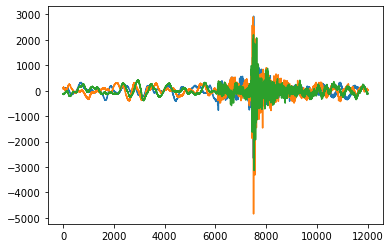

In [4]:
print("Number of examples:", len(generator))
sample = generator[200]
print("Example:", sample)

import matplotlib.pyplot as plt

plt.plot(sample["X"].T);

## Augmentations

Using the generator only to return the waveforms from the dataset does not add much value. However, the generator can be supplemented with augmentations. Let's first try a simple augmentation pipeline, consisting of a random window selection and a normalization.

In [5]:
generator.augmentation(sbg.RandomWindow(windowlen=3000))
generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))

print(generator)

GenericGenerator with 2 augmentations:
 1.	RandomWindow (low=None, high=None)
 2.	Normalize (Detrend (axis=-1), Amplitude normalization (type=peak, axis=-1))



Let's visualize an example. Note that we added a RandomWindow. If you rerun the code, a different window will be selected.

Example: {'X': array([[-0.0264384 , -0.02671978, -0.02707862, ..., -0.07418271,
        -0.09276263, -0.14135411],
       [-0.00889766, -0.00516228, -0.01092773, ...,  0.10669881,
         0.13861585,  0.14967365],
       [-0.03287328, -0.02784196, -0.02977035, ..., -0.06160279,
        -0.07994298, -0.05561053]])}


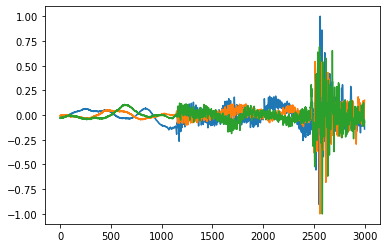

In [6]:
sample = generator[200]
print("Example:", sample)

plt.plot(sample["X"].T);

A standard task in data generation is label generation. Let's generate pick labels for P picks.

In [7]:
generator.augmentation(sbg.ProbabilisticLabeller(label_columns=["trace_P1_arrival_sample"], sigma=50, dim=-2))

print(generator)

GenericGenerator with 3 augmentations:
 1.	RandomWindow (low=None, high=None)
 2.	Normalize (Detrend (axis=-1), Amplitude normalization (type=peak, axis=-1))
 3.	ProbabilisticLabeller (label_type=multi_class, dim=-2)



Let's generate samples. As we can see, samples now have two keys: "X" for the waveforms and "y" for the labels. We visualize both in the plot. Here, labels are encoded probabilistically, but Seisbench offers a range of ways for encoding labels. Check the documentation for details.

*Note: You might need to run the cell multiple times for seeing an annotation, because the P arrival might be outside the random window.*

Sample keys: dict_keys(['X', 'y'])


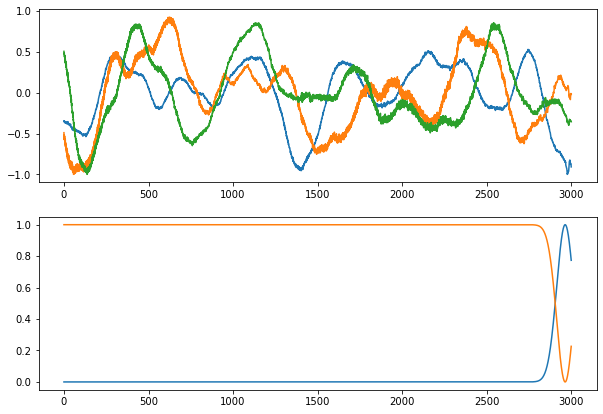

In [8]:
sample = generator[200]
print("Sample keys:", sample.keys())

fig = plt.figure(figsize=(10, 7))
axs = fig.subplots(2, 1)
axs[0].plot(sample["X"].T);
axs[1].plot(sample["y"].T);

## Branching pipelines

Sometimes, it's desirable to build a branching pipeline. For this, most augmentations in SeisBench take a key parameter. Keys can either be pairs of strings, one input and one output key, or a single string, which is used for both input and output. Implicitly, all augmentations except labels assume "X" as key, and all labels assume ("X", "y"), i.e., reading from "X" and writing to "y".

Let's build a pipeline that extracts two windows from the same trace and labels both, but only normalizes one.

In [9]:
generator = sbg.GenericGenerator(data)
generator.augmentation(sbg.RandomWindow(windowlen=3000, key=("X", "X1")))
generator.augmentation(sbg.RandomWindow(windowlen=8000, key=("X", "X2")))
generator.augmentation(sbg.FilterKeys(exclude="X"))
generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1, key="X1"))
generator.augmentation(sbg.ProbabilisticLabeller(label_columns=["trace_P1_arrival_sample"], sigma=50, dim=-2, key=("X1", "y1")))
generator.augmentation(sbg.ProbabilisticLabeller(label_columns=["trace_P1_arrival_sample"], sigma=200, dim=-2, key=("X2", "y2")))

print(generator)

GenericGenerator with 6 augmentations:
 1.	RandomWindow (low=None, high=None)
 2.	RandomWindow (low=None, high=None)
 3.	Filter keys (excludes X)
 4.	Normalize (Detrend (axis=-1), Amplitude normalization (type=peak, axis=-1))
 5.	ProbabilisticLabeller (label_type=multi_class, dim=-2)
 6.	ProbabilisticLabeller (label_type=multi_class, dim=-2)



Sample keys: dict_keys(['X1', 'X2', 'y1', 'y2'])


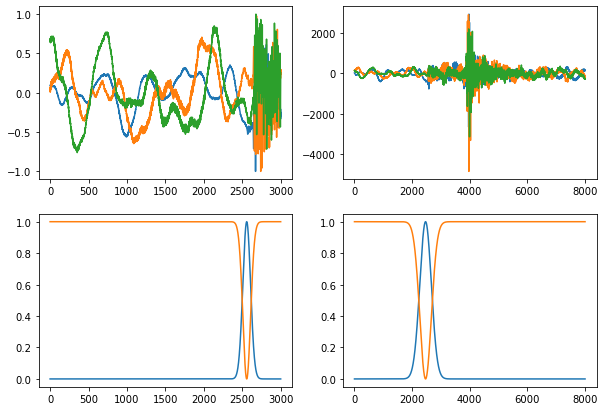

In [10]:
sample = generator[200]
print("Sample keys:", sample.keys())

fig = plt.figure(figsize=(10, 7))
axs = fig.subplots(2, 2)
axs[0, 0].plot(sample["X1"].T);
axs[1, 0].plot(sample["y1"].T);
axs[0, 1].plot(sample["X2"].T);
axs[1, 1].plot(sample["y2"].T);

## Custom augmentations

Seisbench offers a range of built-in augmentations. However, sometime you might want to apply a custom augmentation that is not readily available. To discuss custom augmentation, we need to quickly discuss how SeisBench augmentations are built.

SeisBench augmentations are callable objects, i.e., functions or classes that implement the `__call__` method. Everytime a sample is requested, the generator first retrieves the sample from the dataset and then passes it to all augmentations one after another. For this, each augmentation gets a state dict, which it is expected to modify. Let's build a simple augmentation to inspect the state dict without modifying it. Note that we are using Python's decorator syntax here. However, using the syntax as above is also valid.

In [11]:
generator = sbg.GenericGenerator(data)

@generator.augmentation
def print_state_dict(state_dict):
    print(state_dict)

generator[0];

{'X': (array([[-8.16016656,  2.52308443, -0.55797025, ..., -0.46353076,
         0.12343569, -1.52008214],
       [-5.65052198,  1.68766761,  1.27151696, ..., -0.63567194,
         2.78518374, -1.56848459],
       [-4.45630167,  1.01235445, -0.26532614, ...,  0.81090437,
         0.5250105 , -2.6642456 ]]), {'source_id': '2020zmwrjy', 'source_origin_time': '2020-12-27T02:46:42.620452Z', 'source_origin_uncertainty_sec': nan, 'source_latitude_deg': 47.14764063, 'source_latitude_uncertainty_km': 0.6204931895, 'source_longitude_deg': 6.37134311, 'source_longitude_uncertainty_km': 0.9277545233, 'source_depth_km': 10.965625, 'source_depth_uncertainty_km': 2.11695806, 'split': 'test', 'source_magnitude': 1.965074269, 'source_magnitude_uncertainty': 0.2128535104, 'source_magnitude_type': 'MLhc', 'source_magnitude_author': 'SED', 'path_back_azimuth_deg': 247.11081381, 'station_network_code': 'CH', 'station_code': 'MTI01', 'trace_channel': 'HG', 'station_location_code': nan, 'station_latitude_de

As we can see, the state dict maps a list of keys to tuples. Each tuple consists of a numpy array, commonly the waveforms, and a dictionary of metadata. In the beginning, the generator will populate the state dict with the waveforms and the corresponding metadata row from the dataset. It will use the key "X" for this.

When building an augmentation, it is recommended to keep the metadata consistent with the waveforms. For example, the window selection augmentations automatically modify entries like "trace_p_arrival_sample" to be consistent with the new window borders.

Now that we know of the inner structure of the state dict, let's build a simple augmentation. We'll build an augmentation that reverses the waveforms in time and writes them to a different key.

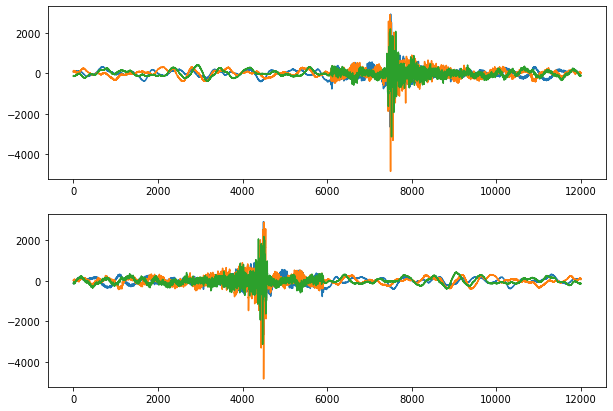

In [12]:
generator = sbg.GenericGenerator(data)

@generator.augmentation
def reverse_waveforms(state_dict):
    waveforms, metadata = state_dict["X"]
    rev_waveforms = waveforms[:, ::-1]
    state_dict["Xr"] = (rev_waveforms, None)  # We write None to indicate that there is no valid metadata here
    
sample = generator[200]

fig = plt.figure(figsize=(10, 7))
axs = fig.subplots(2, 1)
axs[0].plot(sample["X"].T);
axs[1].plot(sample["Xr"].T);

Clearly, custom augmentations can be combined with built-in augmentations as necessary.

## Steered generators

So far we only looked at the `GenericGenerator`. There is another generator in SeisBench, the `SteeredGenerator`. In contrast to the `GenericGenerator`, which gets a dataset, the `SteeredGenerator` gets a dataset and a pandas dataframe with control information. This control information can for example be used to fix the windows that the generator selects for each example. This is for example useful when building evaluation pipelines.

Let's first build a dataframe with control information. Each row needs at least the `trace_name` that it describes. Here we furthermore define a window start and a window end. For simplicity, we use the same samples for each example.

In [13]:
import pandas as pd

control = []

for i in range(200):
    row = data.metadata.iloc[i]
    control_row = {"trace_name": row["trace_name"],
                   "start_sample": 1000,
                   "end_sample": 2000}
    control.append(control_row)

control = pd.DataFrame(control)
control

,trace_name,start_sample,end_sample
0,"bucket1$0,:3,:30001",1000,2000
1,"bucket31$0,:3,:14401",1000,2000
2,"bucket1$1,:3,:30001",1000,2000
3,"bucket0$0,:3,:24001",1000,2000
4,"bucket1$2,:3,:30001",1000,2000
...,...,...,...
195,"bucket0$126,:3,:24001",1000,2000
196,"bucket0$127,:3,:24001",1000,2000
197,"bucket0$128,:3,:24001",1000,2000
198,"bucket0$129,:3,:24001",1000,2000


Now let's create the `SteeredGenerator` using the control frame. We'll only give it one augmentation, the `SteeredWindow`, which selects the window given in the control frame. Note however, that just as for the `GenericGenerator`, all augmentations can be used and combined.

In [14]:
generator = sbg.SteeredGenerator(data, control)
generator.augmentation(sbg.SteeredWindow(windowlen=1000))

print(generator)

SteeredGenerator with 1 augmentations:
 1.	SteeredWindow



Let's now load a sample. As before, we get the sample. Note however, that if you rerun the cell, the sample will stay unchanged, as the steered window always selects the same window as described in the control information.

{'X': array([[ 2.44763588, -1.20235043,  0.86175249, ..., -2.97880178,
         0.98846858, -1.00258536],
       [ 2.47068701, -0.30520958, -0.22972751, ..., -2.04153181,
         1.56905241, -0.66467658],
       [ 3.47353212,  0.00594969,  0.81882761, ..., -1.11923654,
        -0.89663023,  1.11988248]]), 'window_borders': array([   0, 1000])}


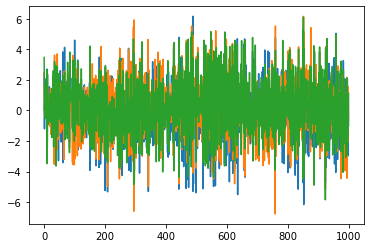

In [15]:
sample = generator[0]
print(sample)

plt.plot(sample["X"].T)

## Outlook

Now you learned the basics of SeisBench generator pipelines. However, we left out one important piece so far: the `GenericGenerator` is a pytorch dataset. This means, that you can directly pass it to a pytorch data loader, which will automatically handle parallel processing and batching. If you want to see an example for this, check the notebook on training a model.